# Cross-slope section

We compute a cross-slope section of fields through gridded data in ACCESS-OM2-01 using the  `metpy.interpolate.cross_section` function; see https://unidata.github.io/MetPy/latest/examples/cross_section.html#sphx-glr-examples-cross-section-py.

Load modules

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr
import xgcm

from metpy.interpolate import cross_section

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Start a cluster with multiple cores

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35469,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:36959,Total threads: 6
Dashboard: /proxy/42865/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:38621,


Nominate a database from which to load the data and define an experiment

In [3]:
# Load database
session = cc.database.create_session()

In [4]:
depth = 3000 # metres

Pick shelf coordinates

In [5]:
shelf_coord = (-62,   -60 + 100)
deep_coord  = (-56.5, -59 + 100)

Load velocity and bathymetry data

In [6]:
# Select data in the southern part of the Southern Ocean
lat_slice = slice(-80, -59)

# We use a time-mean from some output from the RYF run
expt = '01deg_jra55v13_ryf9091'
start_time = '1950-01-31 00:00:00'
end_time = '1959-12-31 00:00:00'

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

In [7]:
## importing density - ignore warnings
pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session,
                               start_time=start_time, end_time=end_time, frequency='1 monthly',
                               attrs={'cell_methods': 'time: mean'},
                               chunks={})

In [8]:
#importing potential temperature - ignore warnings
pot_temp =cc.querying.getvar(expt=expt, variable='pot_temp', 
                             session=session, frequency='1 monthly',
                             attrs={'cell_methods': 'time: mean'},
                             start_time=start_time, end_time=end_time,
                             chunks={})

In [9]:
# Load model grid information with depth
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge([pot_temp.sel(yt_ocean=lat_slice).sel(st_ocean=slice(0, depth)), grid.sel(yu_ocean=lat_slice).sel(yt_ocean=lat_slice)])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_depth = xgcm.Grid(ds, periodic=['X'])
grid_depth

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> outer
  * outer    yu_ocean --> center
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

Take time mean for density and temperature

In [10]:
pot_rho_2 = pot_rho_2.mean(dim = 'time')
pot_rho_2 = pot_rho_2.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0, depth))

In [11]:
pot_temp = pot_temp.mean(dim = 'time')
pot_temp = pot_temp.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0, depth))

Now we make the cross sections using the cross_section function of metpy

In [12]:
#choosing number of steps in cross section
step_no = 400

# Create dataset
ds_pot_rho_2 = xr.Dataset({"pot_rho_2": pot_rho_2, "lat": pot_rho_2.yt_ocean, "lon": pot_rho_2.xt_ocean})

# Interpolate to xu_ocean and yu_ocean
# Rename coordinate names
ds_pot_rho_2 = ds_pot_rho_2.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})

# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_pot_rho_2['x'] = ds_pot_rho_2['x'] + 100
ds_pot_rho_2['x'].attrs = pot_rho_2['xt_ocean'].attrs

# MetPy parsing
pot_rho_2_parsed = ds_pot_rho_2.metpy.parse_cf('pot_rho_2', coordinates={'y': 'y', 'x': 'x'})

pot_rho_2_section = cross_section(pot_rho_2_parsed,
                                  start=(shelf_coord[0], shelf_coord[1]),
                                  end=(deep_coord[0], deep_coord[1]),
                                  steps = step_no,
                                  interp_type='linear')

In [13]:
# Create dataset
ds_pot_temp= xr.Dataset({"pot_temp": pot_temp, "lat": pot_temp.yt_ocean, "lon": pot_temp.xt_ocean})

# Interpolate to xu_ocean and yu_ocean
# Rename coordinate names
ds_pot_temp = ds_pot_temp.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})

# Convert longitude from ACCESS-OM2 range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_pot_temp['x'] = ds_pot_temp['x'] + 100
ds_pot_temp['x'].attrs = pot_temp['xt_ocean'].attrs

# MetPy parsing
pot_temp_parsed = ds_pot_temp.metpy.parse_cf('pot_temp', coordinates={'y': 'y', 'x': 'x'})
pot_temp_section = cross_section(pot_temp_parsed,
                                 start = (shelf_coord[0], shelf_coord[1]),
                                 end = (deep_coord[0], deep_coord[1]),
                                 steps = step_no,
                                 interp_type = 'linear')

In [14]:
# load variables
pot_temp_section.load()
pot_rho_2_section.load();

Finally calculate the distance along the transect (for plotting purposes)

In [15]:
# Define number of points you want to interpolate
step_no = 400

# Radius of the Earth
Rearth = 6371 # km

# Difference between points in lat/lon space
dlon = deep_coord[1] - shelf_coord[1]
dlat = deep_coord[0] - shelf_coord[0]

# Calculate distance in km between the two end points
distance_endpoints = Rearth * np.deg2rad(np.sqrt(dlat**2 + (dlon * np.cos(np.deg2rad(np.mean([shelf_coord[0], deep_coord[0]]))))**2))

# Create array with length of step_no
distance_in_km = np.linspace(0, distance_endpoints, step_no)

# Repeat by the number of depth levels
distance_in_km = np.tile(distance_in_km, (len(pot_temp_section.st_ocean), 1))

## Plotting cross-slope section of potential temperature

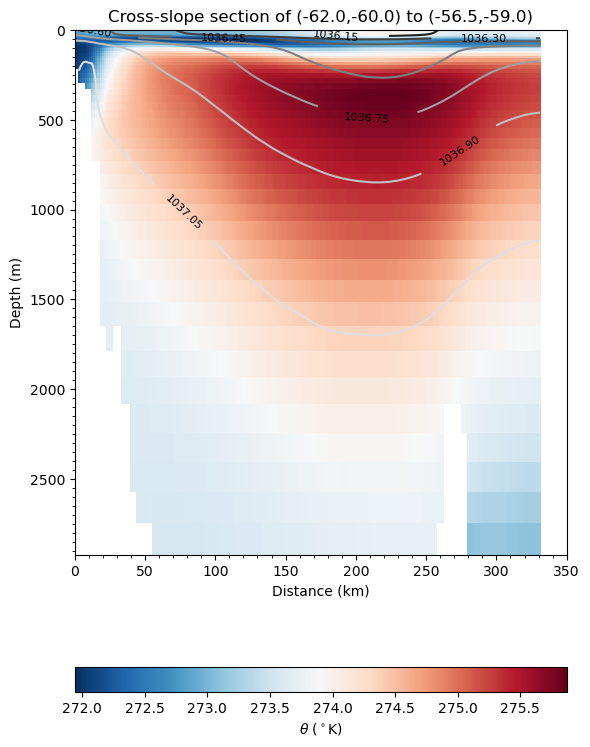

In [16]:
fig, axs = plt.subplots(figsize=(6, 8), sharex = True)

pot_temp_section_top = pot_temp_section.sel(st_ocean=slice(0, 3000))

axs.set_title('Cross-slope section of (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0], shelf_coord[1]-100, deep_coord[0], deep_coord[1]-100))

cmesh = axs.pcolormesh(distance_in_km,
                       pot_temp_section_top.st_ocean.values,
                       pot_temp_section_top.values,
                       cmap = 'RdBu_r')

# Colorbar
cbar = plt.colorbar(cmesh, orientation = 'horizontal')
cbar.set_label(r'$\theta$ ($^\circ$K)')

cs = axs.contour(distance_in_km[0, :],
                 pot_rho_2_section.st_ocean,
                 pot_rho_2_section,
                 cmap = 'gray')

axs.clabel(cs, cs.levels,
           fontsize = 8,
           colors = 'k',
           inline = True,
           use_clabeltext = True)

# Axes
plt.gca().invert_yaxis()
plt.xlim([0, 350])
plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')
axs.xaxis.set_minor_locator(MultipleLocator(10))
axs.yaxis.set_minor_locator(MultipleLocator(50))
plt.tight_layout();

In [17]:
client.close()